In [ ]:
import pandas as pd
import networkx as nx

<img src="/work/visuals/640px-Blur-chart-data-69760.jpg" alt="header" width="600" align="center"/>

#  Market Watch 

**Authors**: Egor Kopylov, Matt Dannheisser, Gaurav Vijaywargia

We are three University of Michigan students that for our Capstone project sought to test our theory that inside of news trends exists predictive signals for the stock market. We believe that that the stock market operates as a metric demonstrating investor sentiments. Those sentiments are often acting reactionary to the news as updates become available. We decided to test this by looking at a specific listed company, Tesla, and counting co-mentions in news articles of Tesla and all other companies listed on the large exchanges in order to build a network model of related companies. We hypothesized that this network would contain signals influencing how companies stock prices would move in conjunction to each other.

**Disclaimer:** We do not recommend that the model contained within be implemented in a real-world trading strategy.


## Requirements

#### Ploomber
The GitHub repo with our source code can be found at [github]("https://github.com/vgaurav-umich/market_watch"). We recommend starting with the [docs/getting-started.md](https://github.com/vgaurav-umich/market_watch/blob/main/docs/getting-started.md) file. We used the Python package, [Ploomber]("https://ploomber.io/") to create a machine learning pipeline. The Ploomber package is an intuitive open-source way to manage resources and monitor versions. We also found Ploomber integration with Jupyter Notebooks to be very helpful as at any stage one can open a .py file with Jupyter and ploomber will automatically read the pipeline.yaml instructions and populate file location variables for dependency file and output file locations.

#### Docker
Our pipeline runs best in a docker container where the pre-built image can be downloaded at [DockerHub]("https://hub.docker.com/r/veenagaurav/market_watch"). Alternatively, instructions of how to create secret files and run via the command line can be found at [getting start with docker]("https://github.com/vgaurav-umich/market_watch/blob/main/docs/getting-started-with-docker.md").

#### Pipenv & Pyenv
It is a recommended practice for python package development to use a virtual environment. This is the best way to resolve library version conflicts. The typical process is to use a python virtual environment like pyenv and pip's requirements.txt to manage the deployment. We decided to use a combined utility called pipenv to manage both virtual environments and pip functionality. The tool wraps around all pip commands and provides an added benefit of updating a Pipfile that replaces requrements.txt. Any package installed/uninstalled via pipenv is  added/deleted automatically in the Pipfile.

## Data Sources 

Python API calls using the requests package were used to query data from three main sources: FRED, Yahoo Finance, and GDELT.

<br>

##### Federal Reserve Economic Data (FRED)
The FRED provides historical data for a broad spectrum of U.S. economy metrics. We chose the following metrics as we believed they portrayed important aspects of the market that are important to Tesla's operations and future earning potential. 
*Metric descriptions provided on each respective FRED page.*
- AD&Co US Mortgage High Yield Index: Is used to assess the broad market returns, risks, opportunities available thru investing in a US mortgage credit risk transfer instrument.
- CBOE Volatility Index VIX : Measures market expectation of near term volatility conveyed by stock index option prices.
- Consumer Price Index for All Urban Consumers: is a price index of a basket of goods and services paid by urban consumers.
- M1 & M1 Velocity: Is the money supply for the most liquid class of assets i.e. currency, demand deposits, and savings deposits.
- M2 & M2 Velocity: Is the money supply for M1 as well as "near money" assets.
- Nominal Broad U.S. Dollar Index: Measures the U.S. dollar against other foreign currencies.
- S&P500 Index: Is a gauge of large capital equities markets.
- Total Consumer Credit Owned and Securitized: Reports outstanding credit extended to households.
- University of Michigan Consumer Sentiment: Consumer surveys that focus on three areas: how consumers view financial prospects and how they view prospects for the general economy for the short term and long term.
**Rationale**
The U.S. having the largest GDP globally has influence over international economies. Furthermore, Americans represent the largest automobile consumer market in the world. The current buying power of the average American has large influence over global automobile sales, especially for high-end brands like Tesla whose vehicles would be considered more of a luxury item than a basic living requirement. 

##### Yahoo Finance
[Yfinance]("https://pypi.org/project/yfinance/") Python package was used to query historical data for individual stocks listed on the NYSE and the NASDAQ. This list of +2,500 companies was filtered to 402 companies that were co-mentioned with Tesla in articles from the GDELT dataset. The dataset included daily open, close, low, and high prices.

##### SEC

We also used Securities and Exchange Commission's (SEC) [EDGAR Data API](https://www.sec.gov/edgar/sec-api-documentation?msclkid=82e1cd8ac23b11ec9680677a88efeb65) to fetch all publicly traded companies info like CIK ID, Name, and any former name used by that entry. SEC Data API contains wealth of information about each publicly traded company including filings done by a company and individuals. 

##### GDELT

GDELT is an aggregator of news articles all over the world. We queried GDELT for articles over a 90-day window, and received a database of organization mentions, as well as the positions of these mentions inside the articles.

 

In [ ]:
pd.read_csv('/work/data/gdelt_gkg_bqdata-raw.csv', index_col='Unnamed: 0').loc[:2,['DATE','DocumentIdentifier','Organizations']]

,DATE,DocumentIdentifier,Organizations
0,20220117230000,https://finance.yahoo.com/news/york-times-ad-w...,"Twitter,2030;Tesla Motors,5461;Bureau Of Trans..."
1,20220117220000,https://techcrunch.com/2022/01/17/new-york-tim...,"Twitter,2036;Tesla Motors,5478;Bureau Of Trans..."
2,20220117223000,https://www.carscoops.com/2022/01/u-s-and-cana...,"Tesla Service,701;Twitter,600;Twitter,1138;Tra..."


## Pipeline

<br>

<img src="/work/pipeline.png">

The above pipeline framework is created automatically by ploomber build.

### Data Acquisition

#### GDELT
We began with using GDELT and were primarily concerned with two aspects of the dataset: the count of company mentions inside of all articles and the count of how many articles contained mentions of a given company and Tesla. We gathered this information by querying GDELT for all articles in a 90-day window. The organization mentions were unstructured and contained a lot of noise. We cleaned the data by adopting typical NLP data processing techniques, i.e: lower casing, tokenization, and stop word removal. We also used manual name mapping for companies known by different names or companies with multiple large brands under one parent. For example: Alphabet Inc, Google, and YouTube all were mapped to Google and Facebook was mapped to Meta. 

We tried two processes for creating a normalized dictionary of names to provide mapping for the unstructured GDELT organizations. One used a brute force iterative process where each company name was pulled from a list of [U.S exchanges]("https://www.nasdaq.com/market-activity/stocks/screener") and each word in the companies name would be iterated on and made into its own organization name i.e. *Honda Motor Company Ltd.* = *Honda, Honda Motor, or Honda Motor Company, Honda Motor Company Inc.* The second approach took a more formal Natural Language Processing technique and used lemmatization to bring all possible terms into common base terms. Then one of two processes were applied. We finally decided on second approach as final one because it let us reduce company names to single or two word token and mapped former names to it. In future we hope to apply Affinity Clustering to the cleaned company names to form name clusters so we can further group similar company names and further reduce noise. The key aspect for clustering is similarity measure used to measure distance between two entities. In this case we plan to use [FuzzyWuzzy](https://pypi.org/project/fuzzywuzzy/?msclkid=08a370a6c23e11ec98abb66a181fce86) python package to measure Levenshtein distance as a measure of similarity. 



### Feature Engineering


##### Creating the Network Model

At this point in the pipeline, we build a network model that represents the strength of relationship between Tesla and the publicly listed companies. The network model is key to testing our theory as it quantifies the relationships based upon the co-mention frequency extracted from the GDELT data. A modified TFIDF function is used to normalize the counts and prevent the largest companies (like Apple, Meta, and Amazon) from dominating this metric.<br>

---

*Modified TFIDF:*
$$
tfidf= tf(c,a) * log(\frac{N}{1 + df(a,c)})
$$  
tf = number of articles "a" mentioning company "c" and Tesla (co-occurrences) <br>
N = sum of all organization mentions in all articles<br>
df= number of company "c" mentions in all articles


---
<br>
This network model was created using a query window of 90 days where ~17,300,000 articles were extracted and ~7,500 of those articles contained mention of Tesla.


<br>

**Top N tickers related to Tesla using normalized counting:**




In [ ]:
network_slider = 61

In [ ]:
!pip install networkx
# Users can adjust the slider above and then rerun this code block to change N
import pandas as pd
import networkx as nx

network = pd.read_csv('/work/data/network.csv')
g = nx.from_pandas_edgelist(network.iloc[:network_slider], 'c1','c2','val')
nx.draw_kamada_kawai(g,with_labels=True, font_size=9, node_size=800, font_color='white')

NameError: name 'network_slider' is not defined

In the above graph nodes are loosely positioned according to their relationship score with Tesla.

## Reinforcement learning training

Reinforcement learning is a branch of data science where researchers have a learning agent which tries to learn how to play a given game. This branch evolved primarily from learning how to play computer games, but it's results can be used far beyond gaming. We tried to transfer the techniques used in this area into an automated trading bot system.

Let's first introduce some basic concepts of reinforcement learning 
- reward - the amount of profit is a reward for a trader buying and selling stocks
- agent - the trading system or trader making decisions about order execution
- environment - 12 US economic metrics combined with the 402 tracked stock tickers weighted by the network model 
- actions - possible decisions that an agent can make in the environment. In our setting it is one of `Buy, Sell, Skip`
- observations - pieces of information that the environment provides to the agent that describe what is happening around the agent


Since there is no labeled dataset and no direct target function, we need to approximate them. In the area of reinforcement learning, one of the widely used techniques is called Q-learning. The main idea of this approach is that the agent will try to predict rewards for each state and action it encounters. Having formulated the problem of learning in such terms, we now have a regression problem which can be solved with different methods. One of these methods is to use deep neural networks. The main benefit of using this approach in our case is that it allows us to learn nonlinear features from a number of signals simultaneously.


## Optimization problem
Our target function $Q$ can be calculated as follows. $$Q(s,a) = E_{s' \in S}\{ r(s,a) + \gamma V(s') \}$$
The loss function $\mathcal{L}$ is calculated using the following formula
$$
y = r + \begin{cases}
      0, \text{ if episode is ended}\\
      \gamma \cdot max_{a' \in A} \hat{Q}(s', a'), \text{ otherwise}\end{cases}
    
$$
where $r$ is the local reward collected in episode, $\hat{Q}$ is the learned on previous iterations of Q function.
$$
\mathcal{L} = (Q(s,a) - y)^2 \rightarrow min
$$

## Neural network architecture


As discussed earlier, we are using open, close, high, and low prices for each company. Similar to the approach used in computer vision we encode these values as signals. We also encode time steps as rows and companies as columns. A more thorough introduction to deep neural networks and convolutions can be found in the article "Pytorch [Basics] — Intro to CNN" by Akshaj Verma. 
To illustrate how we are using convolutions in our network architecture let's look at the illustration from the mentioned article.
![convolutions](/visuals/0*zKUGeho8ljrTlS25.gif)


Instead of having 3 channels, we use 4 price channels (open, close, high and low prices) and 1 channel with company weights previously calculated in our pipeline. We also have kernel of size $5 \times 5$ and 5 output channels.


The 4 price channels are constructed as shown in the following table:
| AAPL | MSFT |   |
| ----------- | ----------- | ----------- | 
| 160.79 | 274.03 | |
| 161 | 270 | |

where AAPL and MSFT are ticker names for Apple and Microsoft. Values in each row represent stock prices of AAPL and MSFT for the corresponding period (day). We intentionally avoided including dates in the dataset to avoid problems with data leakage. However, apart from this measure we also made sure that no future periods are included in the training dataset for each period.
For each price variant (open, close, high and low), we have separate data frames constructed as described above. Each of these datasets are called channels in our deep neural network problem formulation. The shape of each signal is $$m \times n$$, where $m$ is the number of previous values we want to allow our agent to observe. We use 10 bars in our tests for this variable. $n$ represents the number of companies we include in the dataset. In our dataset we calculated for 402 companies and 12 economic metrics.


In addition to the 4 described channels, we also used a data frame of weights from the network model. As raw input we have a vector of weights for each company representing the relationship to the traded company Tesla. Due to the convolutional structure, we had to transform this input into nxm data structure similar to the other channels. We accomplish this task by simply repeating the values of weights the necessary number of times to match the shape of the other channels.

## Deep Reinforcement Learning Model:
The architecture we use can be divided into 2 parts: 

**CNN** 

The first part is the convolutional layer where the networks learns complex features from the market using $5 \times 5$ convolutions described above. It has 4 layers - the first convolutional layer which works with input channels is fed into [ReLu](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) layer. In its turn, this Relu layer is forwarded to another convolutional layer and one more ReLu after. 

**RL**

Since we are using a feed forward network architecture, the second part of the network takes the results of the first as input. It utilizes the technique called Dueling DQN which is thoroughly described in the [DQN chapter](https://learning.oreilly.com/library/view/deep-reinforcement-learning/9781838826994/Text/Chapter_8.xhtml#_idParaDest-134) of the Deep Reinforcement Learning Hands-On book. The main idea of this technique is to split the Q function approximation into two parts. The first one called the value of the state $V(s)$, and the second is the advantage of actions in this state $A(s,a)$ so that $Q(s,a) = V(s) + A(s,a)$. This techniques is implemented in the second part of the network. Before feeding into the second part of the network, we concatenate all results on the previous step and [squeeze](https://pytorch.org/docs/stable/generated/torch.squeeze.html) them into a one-dimensional layer which is directed into two parallel linear network layers. In order to introduce nonlinearity, the standard technique of adding Relu is used on both subnetworks. The Relu is forwarded again to another linear layers which in its turn are combined into the approximation of $Q$ function using the technique described in the [DQN chapter](https://learning.oreilly.com/library/view/deep-reinforcement-learning/9781838826994/Text/Chapter_8.xhtml#_idParaDest-134).
As the output of the described network we have 3 values corresponding to each action - Buy, Sell, Skip. During the training phase, the action is chosen using the epsilon greedy algorithm. The notion of this algorithm is that at first steps the agent tries random actions with higher probability since it needs something to learn from. It chooses random action with decaying probability $\epsilon$.

We had 3 iterations of network architecture.
On the first iteration we wanted to test how the learning agent would behave without feeding it direct prices of the traded stocks. The architecture of this approach is presented on the following graph.

**no direct stock prices**
![arch](/visuals/arch_no_prices.jpeg)

On the second iteration we wanted to test how weights influence the performance of our agent. So we removed weights from input channels and used the following architecture.

**no weights channel**
![arch](/visuals/arch_no_weights.jpeg)

The architecture of the final neural network includes both weights and prices of the stock and is presented on the following image.

**full network**
![arch](/visuals/arch.jpeg)


## Training and validation results



## Training setup

The training process is organized using the ptan library which utilizes

Our training process includes validation each 10 epochs. Validation set is separated from the training at the data preparation step. We use last 50 days of the main dataset as validation dataset and the rest for the training dataset.

We use [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) optimizer with learning rate 0.01. At first, we tried learning rate 0.001, but the training process was too slow so we had to switch to 0.01 value.

## Validation metrics

In reinforcement learning, the learning process is completed in episodes. In this context, the episode means a set of steps, actions, and rewards that define a complete series. For each game, the episode should be defined in a unique way. In our setting, the episode starts at some point in time (random after environment reset after each episode) and completes when the agent runs out of steps or closes the position. The position can be considered closed only after the agent has executed a buy action and then sold off its postition for a profit or loss. In other words, the episode usually ends with selling the purchased stock.

We use 2 validation metrics for each episode:

1. episode reward - calculated as close price of the current episode day minus the buy price and subtracted by commission. This value is divided by the buy price and multiplied by 100%. 
2. order steps - total number of steps from the purchase date until the end of episode

## Results
The following graph illustrates the results of training and validation of our agent. Since the training process takes at least 2 hours to complete and requires GPUs we had a hard time managing constraints in our project. We tried to run the training process of each architecture as many times as we could (from 2 to 5 times each) but we can't claim that we have obtained solid randomized results of hundreds of runs. More time and budget for research is needed in order to confirm our conclusions. With this disclaimer let's discuss some results that we have obtained.

In [ ]:
import json
with open('rl-data/metrics_full.json') as f:
    full = pd.DataFrame(json.loads(f.read()))


with open('rl-data/metrics_no_weights.json') as f:
    no_weights = pd.DataFrame(json.loads(f.read()))

with open('rl-data/metrics_no_prices.json') as f:
    no_prices = pd.DataFrame(json.loads(f.read()))

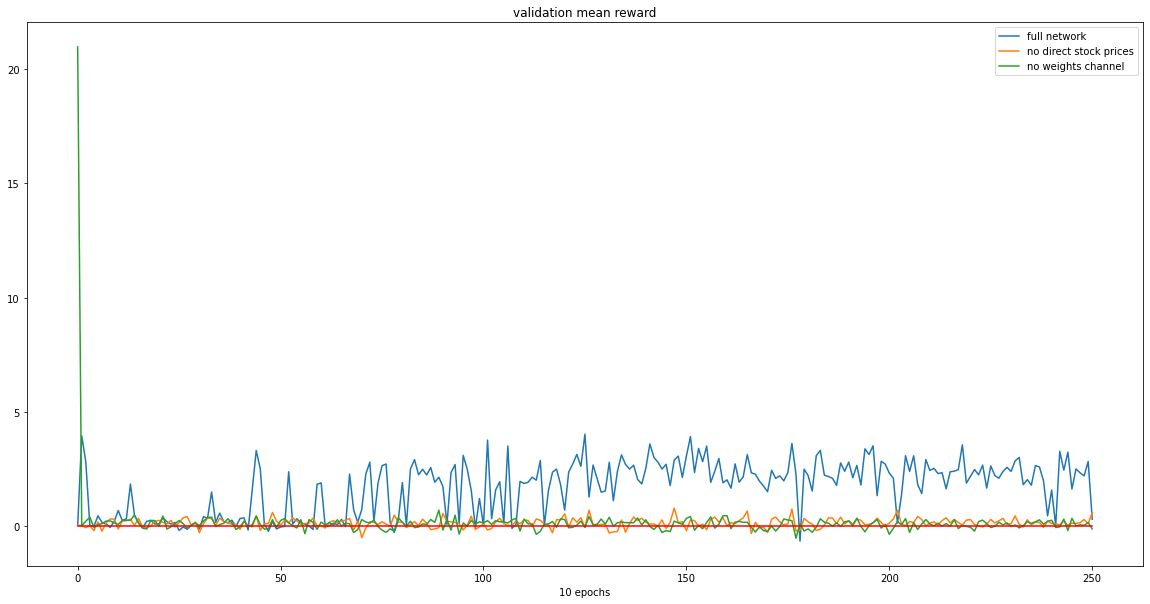

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))

l = min(len(full), len(no_prices), len(no_weights))


full['episode_reward'].iloc[:l].plot(label='full network')
no_prices['episode_reward'].iloc[:l].plot(label='no direct stock prices')
no_weights['episode_reward'].iloc[:l].plot(
    title='validation mean reward',
    label='no weights channel',
    xlabel='10 epochs'
)
plt.plot(np.zeros(l), color='red')
plt.legend()
None

The y-axis is mean reward values of each 10 epochs of optimization on the validation dataset. The red line on the graph represents 0 returns. The validation is completed by running 100 episodes and taking the mean value of each metric. 
- *full network* lines represents the network which includes both direct prices and weights of companies.
- *no direct stock prices* represents the network with weights of companies but no stock prices of the traded company.
- *no weights channel* represents the network with stock prices of the traded company but does not include weights channel.



We see that according to the validation mean reward metric the full network is outperforming the two other models while *no direct stock prices* and *no weights channel* models have similar performance starting from 400 epoch.

Mean and standard deviation statistics of performances is presented in the following table.

In [ ]:
pd.DataFrame({
    'network': ['full network', 'no direct stock prices', 'no weights channel'],
    'mean': np.round([full['episode_reward'].mean(), no_prices['episode_reward'].mean(), no_weights['episode_reward'].mean(), ], 3),
    'standard deviation': np.round([full['episode_reward'].std(), no_prices['episode_reward'].std(), no_weights['episode_reward'].std(), ], 3),

})

,network,mean,standard deviation
0,full network,1.668,1.170
1,no direct stock prices,0.124,0.200
2,no weights channel,0.155,1.269


We see that the most volatile model is *no weights channel* while the least volatile is *no direct stock prices*. *full network* has highest mean value while also having second highest standard deviation.

Let's now analyze another metric we collected - order steps.


Looking at only these results and excluding the above constraints, these results confirm our hypothesis that the computed weights of the companies relative to the traded stock convey significant information for the learning agent and may improve model performance in terms of reward value.

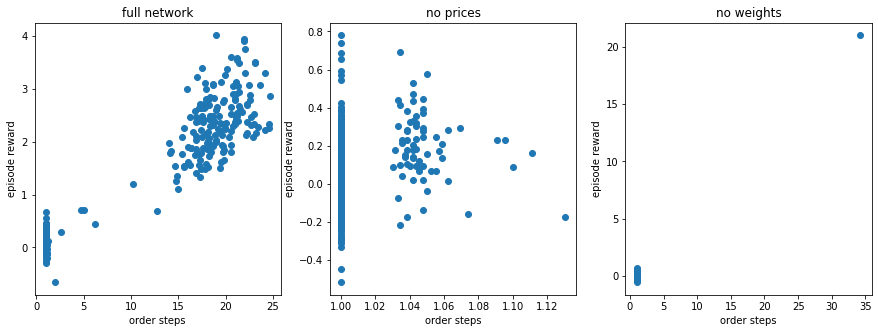

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(131, title='full network')
plt.xlabel('order steps')
plt.ylabel('episode reward')
plt.scatter(full['order_steps'], full['episode_reward'])



plt.subplot(132, title='no prices')
plt.xlabel('order steps')
plt.ylabel('episode reward')
plt.scatter(no_prices['order_steps'], no_prices['episode_reward'])



plt.subplot(133, title='no weights')
plt.xlabel('order steps')
plt.ylabel('episode reward')
plt.scatter(no_weights['order_steps'], no_weights['episode_reward'])


None

We see that significantly higher number of profitable episodes have order steps higher than 2. Let's now explore the distribution of steps of each model.

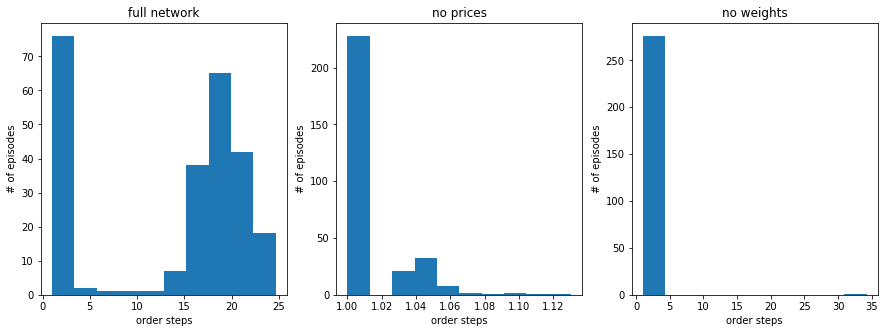

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(131, title='full network')
plt.xlabel('order steps')
plt.ylabel('# of episodes')
plt.hist(full['order_steps'])



plt.subplot(132, title='no prices')
plt.xlabel('order steps')
plt.ylabel('# of episodes')
plt.hist(no_prices['order_steps'])



plt.subplot(133, title='no weights')
plt.xlabel('order steps')
plt.ylabel('# of episodes')
plt.hist(no_weights['order_steps'])
None

In the *full network* model we see that only ~30% of all evaluated episodes have steps count less than 2 while in *no direct stock prices* this ratio is 100%, and for *no weights channel* model it's value is 93%. We may conclude that the only model that learns how to execute longer and more profitable positions is the *full network* model while other models learn only short-term deals around 1-2 days.

# Conclusions, constraints, and future research

A project of this size was ambitious for a team of three. There are a number of items we hope to incorporate in our project in the future. In the following section, we will enumerate through these items with the hope of encouraging and enhancing further work on this topic. 

#### Docker Image
We faced numerous challenges in initial days with building a development environment that worked in all three of our operating systems. Gaurav was using WSL (Windows Subsystem for Linux) on Windows 11, Egor was using Mac OS, while Matt was using Windows to do development. 

One solution that we landed on was to build and use a Docker image for our development environment. This image had all necessary components pre-installed, but we soon realized we were going to have issues with managing the size of our image. At the time of this writing our Docker image stood at ~13GB in size and was causing crashes in WSL.

In the future, we hope to use various techniques available to reduce Docker image size, like - Multi Stage Building and the proper base image.

#### GDELT Data
The core hypothesis for our project is to leverage mentions of publicly traded companies from collections of GDELT articles to inform our RL bot. Our first attempt to extract GDLET data was to use GDELT APIs, but soon we realized that APIs are not an efficient means to extract the data for longer time periods and there is not much support to filter the data as query while calling those APIs.

One solution that ended up using is Google BigQuery's public GDELT dataset. This is a very performant means to get GDELT data and it does allow to filter the data, in our case filtering organizations where TESLA was mentioned.

We only used BigQuery and SQL language for the purpose of data extraction only. In future it would be great area for us to explore full power of BigQuery's scalable infrastructure and SQL's powerful data cleaning/ manipulation functions to do much of heavy lifting of data preparation. Functions, like - Splitting, Regex extraction, replacement, and normalization of strings are very powerful and efficient means to do data preparation within SQL. It does also reduce amount of data we extract and manage in flat files. 

At the current state, our network model is a static network representation of the companies related to Tesla. It ignores the fact that a connection between two companies can be temporary and the relationship strength can fluctuate. An improvement to our model would demand larger processing power and memory and would involve a timeframe indexing of tf-idf scores. These indexed values would be binned based upon a decided bandwidth and would be grouped with the financial and economic data that corresponded to that time bin. 

#### GPU usage
The RL bot uses a deep neural network architecture to do model training. For the size of our problem, we faced issues with the significant runtime of our model training (~2 hours). None of our machine GPU's were able to improve upon Google Colab's runtime. 

We found that Google Collab is a good solution to rent GPUs and run our model training, but it does suffer from lack of full backend server control and does not play nicely with external Docker images.

In future we hope to leverage a powerful GPU enabled machine to our development work or use cluster computing. 

#### Trading agent learning results
From the results we have obtained we have arrived to the following conclusions.
The calculated weighted graph transformed into weights channel and supplied as input to the deep neural network **may significantly improve agent's performance** on the dataset we used. 
We also see several good spots for further research and improvements of our model. Gdelt dataset allows researchers to obtain sentiment values of each article we used to gather information about weights of the companies. This information could be used as another channel for convolutional part of the network architecture.
We also anticipate some improvements in the network architecture both in convolutional and dueling parts. In addition, a more thorough research in terms of the number of episodes validated can also refine our results.
Finally, we used a highly simplified trading model which trades only single stock with one position. A more sophisticated agent with higher number of available actions, strategies and assets can be developed based on our research.


## Scope of Work

**Matt** built the pipeline from data acquisition to network model build. 

**Gaurav** helped with refactoring the data pipeline and streamlining the code up to the network build. In addition he built the Docker image.

**Egor** built and trained the Deep Reinforced Learning model.

### Bibliography

- Andrew Davidson & Co., Inc., AD&Co US Mortgage High Yield Index, Credit-and-Option-Adjusted Spread: Mid-Tier [CROASMIDTIER], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/CROASMIDTIER, April 20, 2022.

- Board of Governors of the Federal Reserve System (US), Total Consumer Credit Owned and Securitized [TOTALSL], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/TOTALSL, April 20, 2022.

- Chicago Board Options Exchange, CBOE Volatility Index: VIX [VIXCLS], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/VIXCLS, April 20, 2022.

- Federal Reserve Bank of St. Louis, Real M1 Money Stock [M1REAL], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/M1REAL, April 20, 2022.

- *GDELT project, The*. GDELT Project. (n.d.). Retrieved April 20, 2022, from https://www.gdeltproject.org/data.html 

- *Stock screener*. Nasdaq. (n.d.). Retrieved April 20, 2022, from https://www.nasdaq.com/market-activity/stocks/screener 

- Team, T. I. (2021, September 13). *What economic indicators are important for investing in the automotive &nbsp;sector?* Investopedia. Retrieved April 20, 2022, from https://www.investopedia.com/ask/answers/040715/what-economic-indicators-are-important-investing-automotive-sector.asp 

- University of Michigan, University of Michigan: Consumer Sentiment [UMCSENT], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/UMCSENT, April 20, 2022.

- U.S. Bureau of Labor Statistics, Consumer Price Index for All Urban Consumers: All Items in U.S. City Average [CPIAUCSL], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/CPIAUCSL, April 20, 2022.

- Yahoo! (n.d.). *Yahoo Finance - Stock Market Live, quotes, Business & Finance News.* Yahoo! Finance. Retrieved April 20, 2022, from https://finance.yahoo.com/ 

- *Yfinance*. PyPI. (n.d.). Retrieved April 20, 2022, from https://pypi.org/project/yfinance/ 
- Pytorch [Basics] — Intro to CNN. Akshaj Verma. Retrieved April 23, 2022, from https://towardsdatascience.com/pytorch-basics-how-to-train-your-neural-net-intro-to-cnn-26a14c2ea29
- Maxim Lapan.  Deep Reinforcement Learning Hands-On Second edition.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=be82e08b-9377-4a15-bbee-2621e4a2398e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>